In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Model bazowy — wersja podstawowa
rf = RandomForestClassifier(
    n_estimators=100,       # liczba drzew (standardowo 100)
    criterion="gini",       # funkcja oceny jakości podziału (gini lub entropy)
    random_state=42,
    n_jobs=-1               # użycie wszystkich rdzeni CPU
)

# Model bazowy (do porównań lub walidacji wstępnej)
baseline_rf = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    random_state=42,
    n_jobs=-1
)


In [ ]:
RS_param_grid_rf = {
    "n_estimators": [10, 50, 100, 150, 200],            # liczba drzew w lesie
    "max_depth": [None, 5, 10, 15, 20],        # maksymalna głębokość drzewa
    "min_samples_split": [2, 5, 8],               # minimalna liczba próbek do podziału węzła
    "min_samples_leaf": [1, 2, 4],                 # minimalna liczba próbek w liściu
    "max_features": ["sqrt", "log2", None],        # liczba cech branych pod uwagę przy podziale
    "bootstrap": [True, False],                    # czy używać bootstrapowania próbek
    "criterion": ["gini", "entropy", "log_loss"],  # funkcja oceny jakości podziału
    "class_weight": [None, "balanced"],            # dla niezbalansowanych danych
}

| Parametr            | Znaczenie                       | Dlaczego wybrany                                                                         |
| ------------------- | ------------------------------- | ---------------------------------------------------------------------------------------- |
| `n_estimators`      | liczba drzew                    | Więcej drzew = stabilniejszy model, ale wolniejszy; zakres 100–1000 daje dobrą równowagę |
| `max_depth`         | głębokość drzewa                | Kontroluje złożoność — zbyt duża = przeuczenie, zbyt mała = niedouczenie                 |
| `min_samples_split` | min. próbki do podziału         | Pomaga ograniczyć zbyt głębokie drzewka                                                  |
| `min_samples_leaf`  | min. próbki w liściu            | Stabilizuje prognozy i redukuje szum                                                     |
| `max_features`      | ile cech wybierać przy podziale | "sqrt" i "log2" to standardowe podejścia w klasyfikacji                                  |
| `bootstrap`         | czy losować z powtórzeniem      | True = klasyczny RF; False = ExtraTrees-like zachowanie                                  |
| `criterion`         | funkcja jakości                 | Można testować `gini`, `entropy` i `log_loss` (nowe w nowszych wersjach sklearn)         |
| `class_weight`      | wagi klas                       | Pomaga przy niezbalansowanych zbiorach danych (np. w binary classification)              |


In [8]:
random_search_rf = RandomizedSearchCV(
    estimator=rf,                        
    param_distributions=RS_param_grid_rf, # siatka hiperparametrów z poprzedniego kroku
    n_iter=25,   #zmniejszam            
    cv=3,                                 # 3-krotna walidacja krzyżowa
    scoring='roc_auc',                    
    verbose=1,
    random_state=42,
    n_jobs=-1
)


In [ ]:
BS_param_grid_rf = {
    "n_estimators": Integer(10, 200),            # liczba drzew — większa = stabilniejszy model, ale wolniejszy
    "max_depth": Integer(2, 20),                   # głębokość drzewa — zbyt duża = przeuczenie
    "min_samples_split": Integer(2, 8),           # minimalna liczba próbek do podziału węzła
    "min_samples_leaf": Integer(1, 5),             # minimalna liczba próbek w liściu
    "max_features": Categorical(["sqrt", "log2", None]),  # ile cech losować — klasyczne podejścia
    "bootstrap": Categorical([True, False]),       # losowanie z powtórzeniem
    "criterion": Categorical(["gini", "entropy", "log_loss"]),  # funkcja oceny podziału
    "class_weight": Categorical([None, "balanced"]) # balans klas
}


| Parametr            | Typ                                            | Dlaczego taki zakres                                                          |
| ------------------- | ---------------------------------------------- | ----------------------------------------------------------------------------- |
| `n_estimators`      | `Integer(100, 1000)`                           | więcej drzew → mniejsze ryzyko przeuczenia, ale większy czas uczenia          |
| `max_depth`         | `Integer(3, 30)`                               | kontroluje złożoność drzew; zbyt mała → niedouczenie, zbyt duża → przeuczenie |
| `min_samples_split` | `Integer(2, 10)`                               | pozwala regulować, kiedy węzeł się jeszcze dzieli                             |
| `min_samples_leaf`  | `Integer(1, 5)`                                | zapewnia, że liście nie są zbyt małe (mniej przeuczenia)                      |
| `max_features`      | `Categorical(["sqrt", "log2", None])`          | standardowe strategie ograniczania liczby cech                                |
| `bootstrap`         | `Categorical([True, False])`                   | True = klasyczny RF, False = bez powtórzeń (czasem lepiej)                    |
| `criterion`         | `Categorical(["gini", "entropy", "log_loss"])` | testujemy różne miary jakości podziału                                        |
| `class_weight`      | `Categorical([None, "balanced"])`              | przydatne przy niezbalansowanych danych                                       |


In [10]:
bayes_rf = BayesSearchCV(
    estimator=rf,
    search_spaces=BS_param_grid_rf,
    n_iter=25, #zmniejszam     # liczba iteracji (prób)
    cv=5,                      # liczba foldów w walidacji krzyżowej
    scoring="roc_auc",         # metryka oceny (można dodać więcej)
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=0
)

# DIABETES

In [22]:
df_diabetes = pd.read_csv("diabetes_transformed.csv")   

X = df_diabetes.drop('diabetes', axis=1)  
y = df_diabetes['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
baseline_rf.fit(X_train, y_train)
y_score_base = baseline_rf.predict_proba(X_test)[:, 1]
baseline_roc = roc_auc_score(y_test, y_score_base)
print(f"Baseline RandomForest (bez tuningu) – Test ROC AUC: {baseline_roc:.4f}")

Baseline RandomForest (bez tuningu) – Test ROC AUC: 0.9724


### RANDOMIZED SEARCH

In [24]:
random_search_rf.fit(X_train, y_train)

results = random_search_rf.cv_results_
num_iterations = len(results['params'])
best_params_random = random_search_rf.best_params_

print("Najlepsze parametry:", best_params_random)

diab_random = pd.DataFrame(results).copy()
diab_random["method"] = "random"
diab_random["iter"] = np.arange(len(diab_random))
diab_random["running_best"] = np.maximum.accumulate(diab_random["mean_test_score"])

y_score_rs = random_search_rf.predict_proba(X_test)[:, 1]
test_roc_rs = roc_auc_score(y_test, y_score_rs)

print(f"RandomSearch – CV mean(best) ROC AUC: {random_search_rf.best_score_:.4f}")
print(f"RandomSearch – Test ROC AUC: {test_roc_rs:.4f}")
print(f"RandomSearch – Liczba iteracji: {num_iterations}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Najlepsze parametry: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': True}
RandomSearch – CV mean(best) ROC AUC: 0.9771
RandomSearch – Test ROC AUC: 0.9801
RandomSearch – Liczba iteracji: 50


### BAYES SEARCH

In [25]:
bayes_rf.fit(X_train, y_train)

print("Najlepsze parametry:", bayes_rf.best_params_)

diab_bayes = pd.DataFrame(bayes_rf.cv_results_).copy()
diab_bayes["method"] = "bayes"
diab_bayes["iter"] = np.arange(len(diab_bayes))
diab_bayes["running_best"] = np.maximum.accumulate(diab_bayes["mean_test_score"])

y_score_bayes = bayes_rf.predict_proba(X_test)[:, 1]
test_roc_bayes = roc_auc_score(y_test, y_score_bayes)

print(f"BayesSearch – CV mean(best) ROC AUC: {bayes_rf.best_score_:.4f}")
print(f"BayesSearch – Test ROC AUC: {test_roc_bayes:.4f}")
print(f"BayesSearch – Liczba iteracji: {len(diab_bayes)}")

Najlepsze parametry: OrderedDict([('bootstrap', True), ('class_weight', None), ('criterion', 'entropy'), ('max_depth', 11), ('max_features', None), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 100)])
BayesSearch – CV mean(best) ROC AUC: 0.9774
BayesSearch – Test ROC AUC: 0.9802
BayesSearch – Liczba iteracji: 60


### WYKRESY

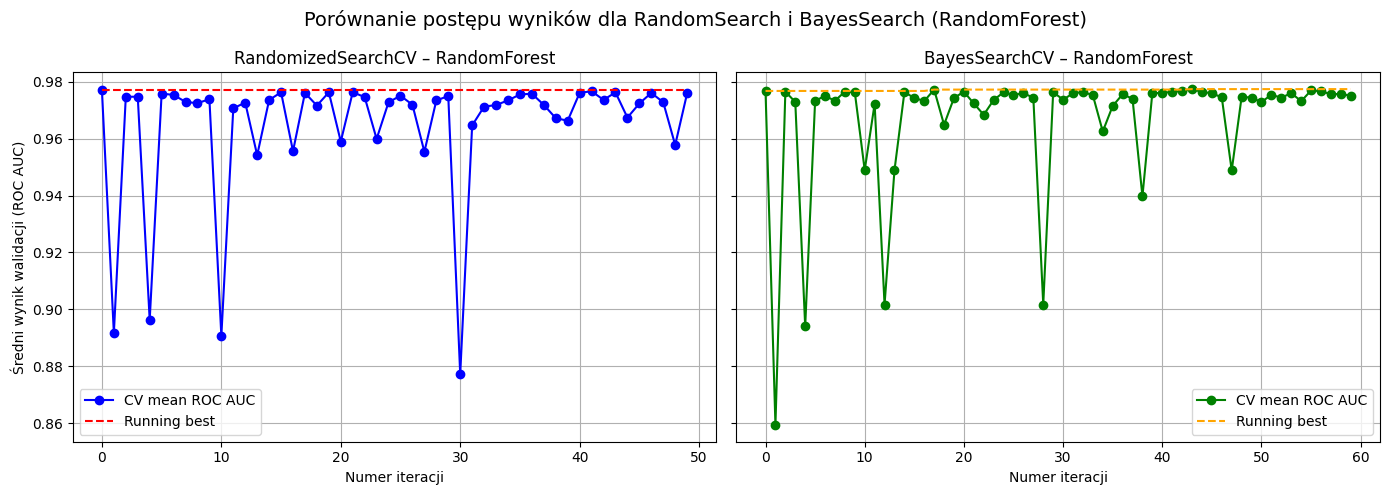

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- RandomizedSearchCV ---
axes[0].plot(
    diab_random["iter"], 
    diab_random["mean_test_score"], 
    marker="o", label="CV mean ROC AUC", color="blue"
)
axes[0].plot(
    diab_random["iter"], 
    diab_random["running_best"], 
    color="red", linestyle="--", label="Running best"
)
axes[0].set_title("RandomizedSearchCV – RandomForest")
axes[0].set_xlabel("Numer iteracji")
axes[0].set_ylabel("Średni wynik walidacji (ROC AUC)")
axes[0].grid(True)
axes[0].legend()

# --- BayesSearchCV ---
axes[1].plot(
    diab_bayes["iter"], 
    diab_bayes["mean_test_score"], 
    marker="o", label="CV mean ROC AUC", color="green"
)
axes[1].plot(
    diab_bayes["iter"], 
    diab_bayes["running_best"], 
    color="orange", linestyle="--", label="Running best"
)
axes[1].set_title("BayesSearchCV – RandomForest")
axes[1].set_xlabel("Numer iteracji")
axes[1].grid(True)
axes[1].legend()

plt.suptitle("Porównanie postępu wyników dla RandomSearch i BayesSearch (RandomForest)", fontsize=14)
plt.tight_layout()
plt.show()


# LOAN

In [37]:
df_loan = pd.read_csv("loan_transformed.csv")   

X = df_loan.drop('charged_off', axis=1)  
y = df_loan['charged_off']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
baseline_rf.fit(X_train, y_train)
y_score_base = baseline_rf.predict_proba(X_test)[:, 1]
baseline_roc = roc_auc_score(y_test, y_score_base)
print(f"Baseline RandomForest (bez tuningu) – Test ROC AUC: {baseline_roc:.4f}")

Baseline RandomForest (bez tuningu) – Test ROC AUC: 0.5415


### RANDOMIZED SEARCH

In [ ]:
random_search_rf.fit(X_train, y_train)

results = random_search_rf.cv_results_
num_iterations = len(results['params'])
best_params_random = random_search_rf.best_params_

print("Najlepsze parametry:", best_params_random)

diab_random = pd.DataFrame(results).copy()
diab_random["method"] = "random"
diab_random["iter"] = np.arange(len(diab_random))
diab_random["running_best"] = np.maximum.accumulate(diab_random["mean_test_score"])

y_score_rs = random_search_rf.predict_proba(X_test)[:, 1]
test_roc_rs = roc_auc_score(y_test, y_score_rs)

print(f"RandomSearch – CV mean(best) ROC AUC: {random_search_rf.best_score_:.4f}")
print(f"RandomSearch – Test ROC AUC: {test_roc_rs:.4f}")
print(f"RandomSearch – Liczba iteracji: {num_iterations}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits


### BAYES SEARCH

In [40]:
bayes_rf.fit(X_train, y_train)

print("Najlepsze parametry:", bayes_rf.best_params_)

diab_bayes = pd.DataFrame(bayes_rf.cv_results_).copy()
diab_bayes["method"] = "bayes"
diab_bayes["iter"] = np.arange(len(diab_bayes))
diab_bayes["running_best"] = np.maximum.accumulate(diab_bayes["mean_test_score"])

y_score_bayes = bayes_rf.predict_proba(X_test)[:, 1]
test_roc_bayes = roc_auc_score(y_test, y_score_bayes)

print(f"BayesSearch – CV mean(best) ROC AUC: {bayes_rf.best_score_:.4f}")
print(f"BayesSearch – Test ROC AUC: {test_roc_bayes:.4f}")
print(f"BayesSearch – Liczba iteracji: {len(diab_bayes)}")

Najlepsze parametry: OrderedDict([('bootstrap', True), ('class_weight', None), ('criterion', 'log_loss'), ('max_depth', 24), ('max_features', None), ('min_samples_leaf', 5), ('min_samples_split', 8), ('n_estimators', 238)])
BayesSearch – CV mean(best) ROC AUC: 0.9734
BayesSearch – Test ROC AUC: 0.9790
BayesSearch – Liczba iteracji: 25


### WYKRESY

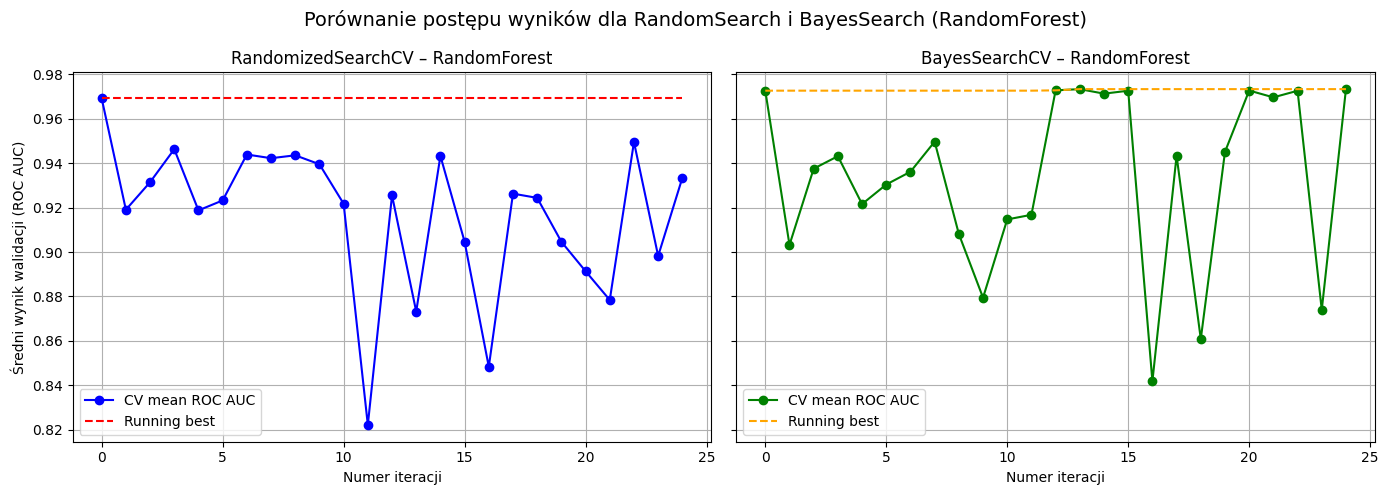

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- RandomizedSearchCV ---
axes[0].plot(
    diab_random["iter"], 
    diab_random["mean_test_score"], 
    marker="o", label="CV mean ROC AUC", color="blue"
)
axes[0].plot(
    diab_random["iter"], 
    diab_random["running_best"], 
    color="red", linestyle="--", label="Running best"
)
axes[0].set_title("RandomizedSearchCV – RandomForest")
axes[0].set_xlabel("Numer iteracji")
axes[0].set_ylabel("Średni wynik walidacji (ROC AUC)")
axes[0].grid(True)
axes[0].legend()

# --- BayesSearchCV ---
axes[1].plot(
    diab_bayes["iter"], 
    diab_bayes["mean_test_score"], 
    marker="o", label="CV mean ROC AUC", color="green"
)
axes[1].plot(
    diab_bayes["iter"], 
    diab_bayes["running_best"], 
    color="orange", linestyle="--", label="Running best"
)
axes[1].set_title("BayesSearchCV – RandomForest")
axes[1].set_xlabel("Numer iteracji")
axes[1].grid(True)
axes[1].legend()

plt.suptitle("Porównanie postępu wyników dla RandomSearch i BayesSearch (RandomForest)", fontsize=14)
plt.tight_layout()
plt.show()


# DEPRESSION

In [2]:
df_depression = pd.read_csv("depression_transformed.csv")   

X = df_depression.drop('History of Mental Illness', axis=1)  
y = df_depression['History of Mental Illness']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
baseline_rf.fit(X_train, y_train)
y_score_base = baseline_rf.predict_proba(X_test)[:, 1]
baseline_roc = roc_auc_score(y_test, y_score_base)
print(f"Baseline RandomForest (bez tuningu) – Test ROC AUC: {baseline_roc:.4f}")

NameError: name 'baseline_rf' is not defined

### RANDOMIZED SEARCH

In [ ]:
random_search_rf.fit(X_train, y_train)

results = random_search_rf.cv_results_
num_iterations = len(results['params'])
best_params_random = random_search_rf.best_params_

print("Najlepsze parametry:", best_params_random)

diab_random = pd.DataFrame(results).copy()
diab_random["method"] = "random"
diab_random["iter"] = np.arange(len(diab_random))
diab_random["running_best"] = np.maximum.accumulate(diab_random["mean_test_score"])

y_score_rs = random_search_rf.predict_proba(X_test)[:, 1]
test_roc_rs = roc_auc_score(y_test, y_score_rs)

print(f"RandomSearch – CV mean(best) ROC AUC: {random_search_rf.best_score_:.4f}")
print(f"RandomSearch – Test ROC AUC: {test_roc_rs:.4f}")
print(f"RandomSearch – Liczba iteracji: {num_iterations}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits


### BAYES SEARCH

In [ ]:
bayes_rf.fit(X_train, y_train)

print("Najlepsze parametry:", bayes_rf.best_params_)

diab_bayes = pd.DataFrame(bayes_rf.cv_results_).copy()
diab_bayes["method"] = "bayes"
diab_bayes["iter"] = np.arange(len(diab_bayes))
diab_bayes["running_best"] = np.maximum.accumulate(diab_bayes["mean_test_score"])

y_score_bayes = bayes_rf.predict_proba(X_test)[:, 1]
test_roc_bayes = roc_auc_score(y_test, y_score_bayes)

print(f"BayesSearch – CV mean(best) ROC AUC: {bayes_rf.best_score_:.4f}")
print(f"BayesSearch – Test ROC AUC: {test_roc_bayes:.4f}")
print(f"BayesSearch – Liczba iteracji: {len(diab_bayes)}")

### WYKRESY

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- RandomizedSearchCV ---
axes[0].plot(
    diab_random["iter"], 
    diab_random["mean_test_score"], 
    marker="o", label="CV mean ROC AUC", color="blue"
)
axes[0].plot(
    diab_random["iter"], 
    diab_random["running_best"], 
    color="red", linestyle="--", label="Running best"
)
axes[0].set_title("RandomizedSearchCV – RandomForest")
axes[0].set_xlabel("Numer iteracji")
axes[0].set_ylabel("Średni wynik walidacji (ROC AUC)")
axes[0].grid(True)
axes[0].legend()

# --- BayesSearchCV ---
axes[1].plot(
    diab_bayes["iter"], 
    diab_bayes["mean_test_score"], 
    marker="o", label="CV mean ROC AUC", color="green"
)
axes[1].plot(
    diab_bayes["iter"], 
    diab_bayes["running_best"], 
    color="orange", linestyle="--", label="Running best"
)
axes[1].set_title("BayesSearchCV – RandomForest")
axes[1].set_xlabel("Numer iteracji")
axes[1].grid(True)
axes[1].legend()

plt.suptitle("Porównanie postępu wyników dla RandomSearch i BayesSearch (RandomForest)", fontsize=14)
plt.tight_layout()
plt.show()


# WEATHER

In [ ]:
df_weather = pd.read_csv("weather_transformed.csv")   

X = df_weather.drop('RainTomorrow', axis=1)  
y = df_weather['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
baseline_rf.fit(X_train, y_train)
y_score_base = baseline_rf.predict_proba(X_test)[:, 1]
baseline_roc = roc_auc_score(y_test, y_score_base)
print(f"Baseline RandomForest (bez tuningu) – Test ROC AUC: {baseline_roc:.4f}")

Baseline RandomForest (bez tuningu) – Test ROC AUC: 0.8931


### RANDOMIZED SEARCH

In [ ]:
random_search_rf.fit(X_train, y_train)

results = random_search_rf.cv_results_
num_iterations = len(results['params'])
best_params_random = random_search_rf.best_params_

print("Najlepsze parametry:", best_params_random)

diab_random = pd.DataFrame(results).copy()
diab_random["method"] = "random"
diab_random["iter"] = np.arange(len(diab_random))
diab_random["running_best"] = np.maximum.accumulate(diab_random["mean_test_score"])

y_score_rs = random_search_rf.predict_proba(X_test)[:, 1]
test_roc_rs = roc_auc_score(y_test, y_score_rs)

print(f"RandomSearch – CV mean(best) ROC AUC: {random_search_rf.best_score_:.4f}")
print(f"RandomSearch – Test ROC AUC: {test_roc_rs:.4f}")
print(f"RandomSearch – Liczba iteracji: {num_iterations}")

### BAYES SEARCH

In [ ]:
bayes_rf.fit(X_train, y_train)

print("Najlepsze parametry:", bayes_rf.best_params_)

diab_bayes = pd.DataFrame(bayes_rf.cv_results_).copy()
diab_bayes["method"] = "bayes"
diab_bayes["iter"] = np.arange(len(diab_bayes))
diab_bayes["running_best"] = np.maximum.accumulate(diab_bayes["mean_test_score"])

y_score_bayes = bayes_rf.predict_proba(X_test)[:, 1]
test_roc_bayes = roc_auc_score(y_test, y_score_bayes)

print(f"BayesSearch – CV mean(best) ROC AUC: {bayes_rf.best_score_:.4f}")
print(f"BayesSearch – Test ROC AUC: {test_roc_bayes:.4f}")
print(f"BayesSearch – Liczba iteracji: {len(diab_bayes)}")

### WYKRESY

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- RandomizedSearchCV ---
axes[0].plot(
    diab_random["iter"], 
    diab_random["mean_test_score"], 
    marker="o", label="CV mean ROC AUC", color="blue"
)
axes[0].plot(
    diab_random["iter"], 
    diab_random["running_best"], 
    color="red", linestyle="--", label="Running best"
)
axes[0].set_title("RandomizedSearchCV – RandomForest")
axes[0].set_xlabel("Numer iteracji")
axes[0].set_ylabel("Średni wynik walidacji (ROC AUC)")
axes[0].grid(True)
axes[0].legend()

# --- BayesSearchCV ---
axes[1].plot(
    diab_bayes["iter"], 
    diab_bayes["mean_test_score"], 
    marker="o", label="CV mean ROC AUC", color="green"
)
axes[1].plot(
    diab_bayes["iter"], 
    diab_bayes["running_best"], 
    color="orange", linestyle="--", label="Running best"
)
axes[1].set_title("BayesSearchCV – RandomForest")
axes[1].set_xlabel("Numer iteracji")
axes[1].grid(True)
axes[1].legend()

plt.suptitle("Porównanie postępu wyników dla RandomSearch i BayesSearch (RandomForest)", fontsize=14)
plt.tight_layout()
plt.show()
